In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio

from toneEncoder import ToneEncoder
from datasets import AmpPairDataset
from generator import FiLMGCNBlock, GeneratorFiLMGCN, CondNet, FusionMLP, ResidualFusionMLP
from losses import ComplexSpectralLoss, SpectralLoss, MRSTFTLoss
from helper import peak_normalize, loudness_match

def train_generator(train_df, val_df, tone_ckpt,
                    epochs=50, bs=12, lr=1e-4, device='cuda'):
    # load tone encoder E
    toneE = ToneEncoder()    # 请换成你自己的 SimCLR+proj 512→128 实现
    toneE.load_state_dict(torch.load(tone_ckpt))
    toneE.to(device)

    # dataset & loader
    ds_tr = AmpPairDataset(train_df, clip_sec=3.5, device=device);  dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=0)
    ds_va = AmpPairDataset(val_df, clip_sec=3.5, device=device);  dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=0)

    C    = CondNet().to(device)
    G    = GeneratorFiLMGCN().to(device)
    fusion_mlp = ResidualFusionMLP(in_dim=256, hidden_dim=256, out_dim=128).to(device)
    loss_fn = MRSTFTLoss(ffts=[1024], alpha_spec=0.9, alpha_time=0.1).to(device)
    # loss_fn = ComplexSpectralLoss(n_fft=2048, hop_length=512, alpha_rms=1).to(device)
    # loss_fn = SpectralLoss().to(device)
    opt = torch.optim.Adam(
        list(C.parameters())
      + list(fusion_mlp.parameters())
      + list(G.parameters()),
        lr=lr
    )
    # 在验证损失 plateau 后，lr = lr * factor
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, min_lr=1e-7)
    
    best_val = float('inf')
    for ep in range(1, epochs+1):
        C.train(); G.train();  t_loss = 0
        toneE.eval()
        for x,y,z,c in dl_tr:
            x,y,z,c = x.to(device), y.to(device), z.to(device), c.to(device)
            with torch.no_grad():
                φ_z = toneE(z)      
            φ_c = C(c)
            # 只在确实多出一个首维（1）时才 squeeze
            if φ_z.dim() == 3 and φ_z.shape[0] == 1:
                φ_z = φ_z.squeeze(0)
            if φ_c.dim() == 3 and φ_c.shape[0] == 1:
                φ_c = φ_c.squeeze(0)
            φ       = fusion_mlp(φ_z, φ_c)  
            # φ = 0.8 * φ_z + 0.2 * φ
            ŷ = G(x,φ)
            loss = loss_fn(ŷ, y)
            opt.zero_grad(); loss.backward(); opt.step()
            t_loss += loss.item()
        t_loss /= len(dl_tr)

        G.eval(); v_loss = 0
        with torch.no_grad():
            for x,y,z,c in dl_va:
                x,y,z,c = x.to(device), y.to(device), z.to(device), c.to(device)
                with torch.no_grad():
                    φ_z = toneE(z)
                φ_c = C(c)
                if φ_z.dim() == 3 and φ_z.shape[0] == 1:
                    φ_z = φ_z.squeeze(0)
                if φ_c.dim() == 3 and φ_c.shape[0] == 1:
                    φ_c = φ_c.squeeze(0)

                # print("φ_z:", φ_z.shape, "  φ_c:", φ_c.shape)
                φ       = fusion_mlp(φ_z, φ_c) 
                # φ = 0.8 * φ_z + 0.2 * φ
                v_loss += loss_fn(G(x,φ), y).item()
        v_loss /= len(dl_va)
        scheduler.step(v_loss)
        current_lr = opt.param_groups[0]['lr']
        print(f"Epoch {ep:2d} | lr={current_lr:.1e}  train={t_loss:.4f}  val={v_loss:.4f}")
        if v_loss < best_val:
            best_val = v_loss
            torch.save(G.state_dict(), "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth")
            torch.save(C.state_dict(), "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth")
            torch.save(fusion_mlp.state_dict(), "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth")

    return G, C, fusion_mlp

# -----------------------------
# 6) 开始训练示例
# -----------------------------
if __name__=="__main__":
    import pandas as pd
    # train_pairs.csv/val_pairs.csv: 包含 direct_input/output/tone_ref_path
    df_tr = pd.read_csv("train.csv")
    df_va = pd.read_csv("val.csv")
    G, C, fusion_mlp = train_generator(df_tr, df_va, epochs=80, bs=8, tone_ckpt="best_supcon_tone_encoder.pth")
    torch.save(G.state_dict(), "Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth")
    torch.save(C.state_dict(), "Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth")
    torch.save(fusion_mlp.state_dict(), "Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth")

Epoch  1 | lr=1.0e-04  train=0.0715  val=0.0667
Epoch  2 | lr=1.0e-04  train=0.0666  val=0.0657
Epoch  3 | lr=1.0e-04  train=0.0651  val=0.0629
Epoch  4 | lr=1.0e-04  train=0.0633  val=0.0623
Epoch  5 | lr=1.0e-04  train=0.0622  val=0.0615
Epoch  6 | lr=1.0e-04  train=0.0616  val=0.0640
Epoch  7 | lr=1.0e-04  train=0.0612  val=0.0611
Epoch  8 | lr=1.0e-04  train=0.0606  val=0.0591
Epoch  9 | lr=1.0e-04  train=0.0603  val=0.0603
Epoch 10 | lr=1.0e-04  train=0.0597  val=0.0589
Epoch 11 | lr=1.0e-04  train=0.0596  val=0.0588
Epoch 12 | lr=1.0e-04  train=0.0594  val=0.0588
Epoch 13 | lr=1.0e-04  train=0.0591  val=0.0584
Epoch 14 | lr=1.0e-04  train=0.0590  val=0.0579
Epoch 15 | lr=1.0e-04  train=0.0586  val=0.0590
Epoch 16 | lr=1.0e-04  train=0.0586  val=0.0581
Epoch 17 | lr=1.0e-04  train=0.0585  val=0.0584
Epoch 18 | lr=5.0e-05  train=0.0583  val=0.0594
Epoch 19 | lr=5.0e-05  train=0.0578  val=0.0572
Epoch 20 | lr=5.0e-05  train=0.0576  val=0.0577
Epoch 21 | lr=5.0e-05  train=0.0576  val

In [14]:
import torch, torchaudio, numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

from toneEncoder       import ToneEncoder
from generator         import GeneratorFiLMGCN, CondNet, FusionMLP, ResidualFusionMLP
from losses            import MRSTFTLoss
from datasets          import AmpPairDataset    # 你原先的 one-shot dataset
from helper            import loudness_match

# ---------- 用户配置 ----------
di_wav     = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/001_lorcan_metal_rhythm.wav"          # 纯 DI 输入
ref_wav    = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/00000751.wav"   # 参考音箱 tone
out_wav    = "/root/autodl-tmp/code/Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.wav"      # 输出路径
encoder_ckpt = "best_supcon_tone_encoder.pth"
g_ckpt       = "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth"
c_ckpt       = "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth"
f_ckpt       = "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth"
device       = "cuda" if torch.cuda.is_available() else "cpu"
sr           = 48_000
clip_sec     = 3.5                  # 与训练一致
overlap      = 0.75                 # 25% hop
# --------------------------------

# ========= 1. 加载模型 =========

encoder = ToneEncoder().to(device)
encoder.load_state_dict(torch.load(encoder_ckpt, map_location=device))
encoder.eval()

gen = GeneratorFiLMGCN().to(device)
gen.load_state_dict(torch.load(g_ckpt, map_location=device))
gen.eval()

cond_net = CondNet().to(device)
cond_net.load_state_dict(torch.load(c_ckpt, map_location=device))
cond_net.eval()

fusion_mlp = ResidualFusionMLP().to(device)
fusion_mlp.load_state_dict(torch.load(f_ckpt, map_location=device))
fusion_mlp.eval()
# ========= 2. 实用函数 =========
def to_mono(wav):               # [C,T] → [1,T]
    return wav.mean(0, keepdim=True)

def peak_norm(x, tgt_db=-12):
    peak = x.abs().max()
    if peak>0:
        x = x * (10**(tgt_db/20) / peak)
    return x

def frame_signal(x, frame_len, hop):
    # x:[1,T] → [N,1,L]
    T = x.size(1)
    idx = torch.arange(0, T-frame_len+1, hop)
    frames = torch.stack([x[:, i:i+frame_len] for i in idx])
    return frames, idx

def overlap_add(frames, idx, T, hop, window=False):
    y = torch.zeros(1, T)
    acc = torch.zeros_like(y)
    win = torch.hann_window(frames.size(-1)).unsqueeze(0) if window else 1.0
    for f, start in zip(frames, idx):
        y[:, start:start+f.size(-1)] += (f * win)
        acc[:, start:start+f.size(-1)] += win
    return (y / acc.clamp_min(1e-6))


# ========= 3. 读取音频 =========
di, sr0  = torchaudio.load(di_wav)
ref, sr1 = torchaudio.load(ref_wav)
print(sr0, sr1, sr)
assert sr0==sr1==sr, "采样率不一致"

di  = peak_norm(to_mono(di))
ref = peak_norm(to_mono(ref))

# # ========= 4. 计算 tone embedding φ =========
# with torch.no_grad():
#     φ = encoder(ref.to(device)).squeeze(0)   # [128]

# # ========= 5. 分块 + 推理 =========
frame_len = int(sr*clip_sec)
hop_len   = int(frame_len * (1-overlap))
# frames, idx = frame_signal(di, frame_len, hop_len)   # [N,1,L]
# frames  = frames.to(device)
# φ_batch = φ.repeat(frames.size(0), 1)                 # [N,128]

# out_frames = []
# with torch.no_grad():
#     for i in tqdm(range(0, frames.size(0), 8)):
#         f = frames[i:i+8]           # 小批量
#         p = φ_batch[i:i+8]
#         y_hat = gen(f, p)           # [B,1,L]
#         out_frames.append(y_hat)
# out_frames = torch.cat(out_frames, dim=0)             # [N,1,L]

# # ========= 6. Overlap-Add & 写文件 =========
# T_total = di.size(1)
# wet = overlap_add(out_frames, idx, T_total, hop_len)  # [1,T]
# # wet = loudness_match(ref, wet)
# torchaudio.save(out_wav, wet, sr)
# print(f"✅ Done! 保存到 {out_wav}")
# --- 1. 计算 tone embedding φ_z ---
φ_z = encoder(ref.to(device))
if φ_z.dim() == 2 and φ_z.size(0) == 1:
    φ_z = φ_z.squeeze(0)  # [128]

    
df = pd.read_csv("train.csv")   # 注意路径是否正确
knob_cols = ['gain','mid','bass','treble']
group = df.groupby('model')[knob_cols]
knob_min_by_model = group.min()
knob_max_by_model = group.max()
knob_range_by_model = (knob_max_by_model - knob_min_by_model).replace(0, 1e-6)

# 2. 手动指定 amplifier model name 和原始 knob（记得按顺序：gain, mid, bass, treble）
model_name = "USA Lead"  # 你当前输入音频的模型
raw_knobs = torch.tensor([2, 0.3, 0.4, 0.4], device=device)  # 你的 raw 值

# 3. Normalize
knob_min = torch.tensor(knob_min_by_model.loc[model_name].values, device=device)
knob_range = torch.tensor(knob_range_by_model.loc[model_name].values, device=device)
normalized_knobs = ((raw_knobs - knob_min) / knob_range).float()
    
print(normalized_knobs)
    
# (可选) 默认旋钮
φ_c = cond_net(normalized_knobs).squeeze(0)  # [128]
# φ = fusion_mlp(torch.cat([φ_z, φ_c], dim=-1))  # [128]
# φ = φ_z + φ_c  # [128]
φ       = fusion_mlp(φ_z, φ_c) 
# φ = φ_z
# --- 2. 分帧 ---
frames, idx = frame_signal(di, frame_len, hop_len)  # frames:[N,1,L]
frames  = frames.to(device)
φ_batch = φ.repeat(frames.size(0), 1)               # [N,128]

out_frames = []
with torch.no_grad():
    for i in tqdm(range(0, frames.size(0), 8)):
        f = frames[i:i+8]
        p = φ_batch[i:i+8]
        y_hat = gen(f, p)
        out_frames.append(y_hat.cpu())              # 移回 CPU 省显存
out_frames = torch.cat(out_frames, dim=0)

# --- 3. Overlap-Add (no extra window) ---
wet = overlap_add(out_frames, idx, di.size(1), hop_len, window=False)
torchaudio.save(out_wav, wet, sr)

48000 48000 48000
tensor([2.1111, 0.2222, 0.3333, 0.3333], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


In [7]:
cos = F.cosine_similarity(φ, φ_z, dim=-1).mean()
print("Cosine similarity (φ vs φ_z):", cos.item())


Cosine similarity (φ vs φ_z): -0.05149552971124649


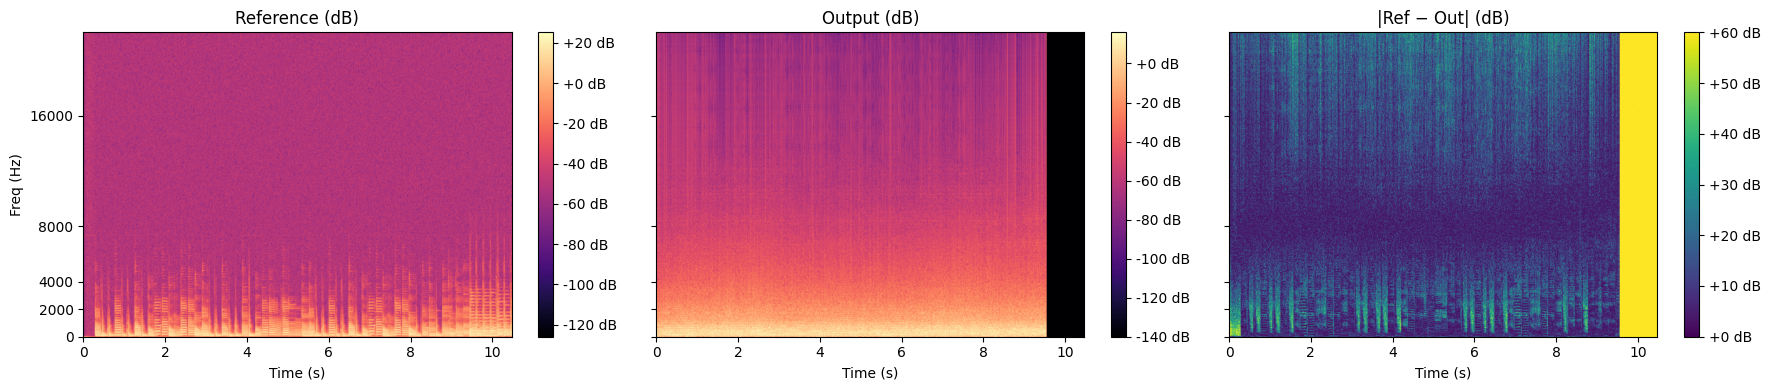

In [13]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

def plot_stft_comparison(y_true, y_pred, sample_rate=44100, n_fft=1024, hop_length=256):
    # squeeze channel dim if needed
    if y_true.dim() == 2 and y_true.size(0) == 1:
        y_true = y_true.squeeze(0)
    if y_pred.dim() == 2 and y_pred.size(0) == 1:
        y_pred = y_pred.squeeze(0)

    # STFT
    spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=1.0)
    S_true = spec(y_true)  # [freq_bins, time_frames]
    S_pred = spec(y_pred)

    # align time frames
    T = min(S_true.size(-1), S_pred.size(-1))
    S_true = S_true[..., :T]
    S_pred = S_pred[..., :T]

    # to dB
    S_true_db = 20 * torch.log10(S_true + 1e-7)
    S_pred_db = 20 * torch.log10(S_pred + 1e-7)
    S_diff = torch.abs(S_true_db - S_pred_db)

    # prepare freq/time vectors
    freq_bins = S_true_db.shape[0]
    times = np.arange(T) * hop_length / sample_rate
    freqs = np.linspace(0, sample_rate/2, freq_bins)

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
    im0 = axes[0].imshow(S_true_db.numpy(), origin='lower',
                         aspect='auto', cmap='magma',
                         extent=[times[0], times[-1], freqs[0], freqs[-1]])
    axes[0].set(title='Reference (dB)', xlabel='Time (s)', ylabel='Freq (Hz)')
    fig.colorbar(im0, ax=axes[0], format='%+2.0f dB')

    im1 = axes[1].imshow(S_pred_db.numpy(), origin='lower',
                         aspect='auto', cmap='magma',
                         extent=[times[0], times[-1], freqs[0], freqs[-1]])
    axes[1].set(title='Output (dB)', xlabel='Time (s)')
    fig.colorbar(im1, ax=axes[1], format='%+2.0f dB')

    im2 = axes[2].imshow(S_diff.numpy(), origin='lower',
                         aspect='auto', cmap='viridis',
                         vmin=0, vmax=60,
                         extent=[times[0], times[-1], freqs[0], freqs[-1]])
    axes[2].set(title='|Ref − Out| (dB)', xlabel='Time (s)')
    fig.colorbar(im2, ax=axes[2], format='%+2.0f dB')

    # set nice yticks at e.g. 0,2k,4k,8k,16k
    yticks = [0, 2000, 4000, 8000, 16000]
    for ax in axes:
        ax.set_yticks(yticks)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume y and y_hat are 1D torch tensors loaded from your validation set
# y, y_hat = ... 
plot_stft_comparison(ref, wet)




In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio

from toneEncoder import ToneEncoder
from datasets import AmpPairDataset
from generator import FiLMGCNBlock, GeneratorFiLMGCN, CondNet, FusionMLP, ResidualFusionMLP, DeepFusionMLP
from losses import ComplexSpectralLoss, SpectralLoss, MRSTFTLoss
from helper import peak_normalize, loudness_match

def train_generator(train_df, val_df, tone_ckpt,
                    epochs=50, bs=12, lr=1e-4, device='cuda'):
    # load tone encoder E
    toneE = ToneEncoder()    # 请换成你自己的 SimCLR+proj 512→128 实现
    toneE.load_state_dict(torch.load(tone_ckpt))
    toneE.to(device)

    # dataset & loader
    ds_tr = AmpPairDataset(train_df, clip_sec=3.5, device=device);  dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=0)
    ds_va = AmpPairDataset(val_df, clip_sec=3.5, device=device);  dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=0)

    C    = CondNet(in_dim=1, out_dim=16).to(device)
    G    = GeneratorFiLMGCN().to(device)
    fusion_mlp = DeepFusionMLP(in_dim=144, hidden_dim=64, out_dim=128).to(device)
    loss_fn = MRSTFTLoss(ffts=[1024], alpha_spec=0.9, alpha_time=0.1).to(device)
    # loss_fn = ComplexSpectralLoss(n_fft=2048, hop_length=512, alpha_rms=1).to(device)
    # loss_fn = SpectralLoss().to(device)
    opt = torch.optim.Adam(
        list(C.parameters())
      + list(fusion_mlp.parameters())
      + list(G.parameters()),
        lr=lr
    )
    # 在验证损失 plateau 后，lr = lr * factor
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, min_lr=1e-7)
    
    best_val = float('inf')
    for ep in range(1, epochs+1):
        C.train(); G.train();  t_loss = 0
        toneE.eval()
        for x,y,z,c in dl_tr:
            x,y,z,c = x.to(device), y.to(device), z.to(device), c.to(device)
            with torch.no_grad():
                φ_z = toneE(z)      
            φ_c = C(c)
            # 只在确实多出一个首维（1）时才 squeeze
            if φ_z.dim() == 3 and φ_z.shape[0] == 1:
                φ_z = φ_z.squeeze(0)
            if φ_c.dim() == 3 and φ_c.shape[0] == 1:
                φ_c = φ_c.squeeze(0)
            φ_cat   = torch.cat([φ_z, φ_c], dim=-1)
            φ       = fusion_mlp(φ_cat)  
            # φ = 0.8 * φ_z + 0.2 * φ
            ŷ = G(x,φ)
            loss = loss_fn(ŷ, y)
            opt.zero_grad(); loss.backward(); opt.step()
            t_loss += loss.item()
        t_loss /= len(dl_tr)

        G.eval(); v_loss = 0
        with torch.no_grad():
            for x,y,z,c in dl_va:
                x,y,z,c = x.to(device), y.to(device), z.to(device), c.to(device)
                with torch.no_grad():
                    φ_z = toneE(z)
                φ_c = C(c)
                if φ_z.dim() == 3 and φ_z.shape[0] == 1:
                    φ_z = φ_z.squeeze(0)
                if φ_c.dim() == 3 and φ_c.shape[0] == 1:
                    φ_c = φ_c.squeeze(0)

                # print("φ_z:", φ_z.shape, "  φ_c:", φ_c.shape)
                φ_cat   = torch.cat([φ_z, φ_c], dim=-1)
                φ       = fusion_mlp(φ_cat)  
                # φ = 0.8 * φ_z + 0.2 * φ
                v_loss += loss_fn(G(x,φ), y).item()
        v_loss /= len(dl_va)
        scheduler.step(v_loss)
        current_lr = opt.param_groups[0]['lr']
        print(f"Epoch {ep:2d} | lr={current_lr:.1e}  train={t_loss:.4f}  val={v_loss:.4f}")
        if v_loss < best_val:
            best_val = v_loss
            torch.save(G.state_dict(), "Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth")
            torch.save(C.state_dict(), "Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth")
            torch.save(fusion_mlp.state_dict(), "Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth")

    return G, C, fusion_mlp

# -----------------------------
# 6) 开始训练示例
# -----------------------------
if __name__=="__main__":
    import pandas as pd
    # train_pairs.csv/val_pairs.csv: 包含 direct_input/output/tone_ref_path
    df_tr = pd.read_csv("train.csv")
    df_va = pd.read_csv("val.csv")
    G, C, fusion_mlp = train_generator(df_tr, df_va, epochs=80, bs=8, tone_ckpt="best_supcon_tone_encoder.pth")
    torch.save(G.state_dict(), "Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth")
    torch.save(C.state_dict(), "Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth")
    torch.save(fusion_mlp.state_dict(), "Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth")

Epoch  1 | lr=1.0e-04  train=0.0732  val=0.0689
Epoch  2 | lr=1.0e-04  train=0.0686  val=0.0654
Epoch  3 | lr=1.0e-04  train=0.0660  val=0.0727
Epoch  4 | lr=1.0e-04  train=0.0650  val=0.0648
Epoch  5 | lr=1.0e-04  train=0.0640  val=0.0621
Epoch  6 | lr=1.0e-04  train=0.0631  val=0.0635
Epoch  7 | lr=1.0e-04  train=0.0624  val=0.0610
Epoch  8 | lr=1.0e-04  train=0.0619  val=0.0606
Epoch  9 | lr=1.0e-04  train=0.0613  val=0.0615
Epoch 10 | lr=1.0e-04  train=0.0609  val=0.0599
Epoch 11 | lr=1.0e-04  train=0.0602  val=0.0593
Epoch 12 | lr=1.0e-04  train=0.0599  val=0.0599
Epoch 13 | lr=1.0e-04  train=0.0597  val=0.0592
Epoch 14 | lr=1.0e-04  train=0.0593  val=0.0583
Epoch 15 | lr=1.0e-04  train=0.0590  val=0.0585
Epoch 16 | lr=1.0e-04  train=0.0590  val=0.0594
Epoch 17 | lr=1.0e-04  train=0.0587  val=0.0579
Epoch 18 | lr=1.0e-04  train=0.0587  val=0.0578
Epoch 19 | lr=1.0e-04  train=0.0586  val=0.0580
Epoch 20 | lr=1.0e-04  train=0.0584  val=0.0586
Epoch 21 | lr=1.0e-04  train=0.0582  val

In [5]:
import torch, torchaudio, numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

from toneEncoder       import ToneEncoder
from generator         import GeneratorFiLMGCN, CondNet, FusionMLP, ResidualFusionMLP, DeepFusionMLP
from losses            import MRSTFTLoss
from datasets          import AmpPairDataset    # 你原先的 one-shot dataset
from helper            import loudness_match

# ---------- 用户配置 ----------
di_wav     = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/001_lorcan_metal_rhythm.wav"          # 纯 DI 输入
ref_wav    = "/root/autodl-tmp/unzipped/Fractal - FM3 - USA Lead/USA Lead/001_lorcan_metal_rhythm/00000751.wav"   # 参考音箱 tone
out_wav    = "/root/autodl-tmp/code/Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.wav"      # 输出路径
encoder_ckpt = "best_supcon_tone_encoder.pth"
g_ckpt       = "Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth"
c_ckpt       = "Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth"
f_ckpt       = "Best_Con_DResidual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth"
device       = "cuda" if torch.cuda.is_available() else "cpu"
sr           = 48_000
clip_sec     = 3.5                  # 与训练一致
overlap      = 0.75                 # 25% hop
# --------------------------------

# ========= 1. 加载模型 =========

encoder = ToneEncoder().to(device)
encoder.load_state_dict(torch.load(encoder_ckpt, map_location=device))
encoder.eval()

gen = GeneratorFiLMGCN().to(device)
gen.load_state_dict(torch.load(g_ckpt, map_location=device))
gen.eval()

cond_net = CondNet(in_dim=1, out_dim=16).to(device)
cond_net.load_state_dict(torch.load(c_ckpt, map_location=device))
cond_net.eval()

fusion_mlp = DeepFusionMLP(in_dim=144, hidden_dim=64, out_dim=128).to(device)
fusion_mlp.load_state_dict(torch.load(f_ckpt, map_location=device))
fusion_mlp.eval()
# ========= 2. 实用函数 =========
def to_mono(wav):               # [C,T] → [1,T]
    return wav.mean(0, keepdim=True)

def peak_norm(x, tgt_db=-12):
    peak = x.abs().max()
    if peak>0:
        x = x * (10**(tgt_db/20) / peak)
    return x

def frame_signal(x, frame_len, hop):
    # x:[1,T] → [N,1,L]
    T = x.size(1)
    idx = torch.arange(0, T-frame_len+1, hop)
    frames = torch.stack([x[:, i:i+frame_len] for i in idx])
    return frames, idx

def overlap_add(frames, idx, T, hop, window=False):
    y = torch.zeros(1, T)
    acc = torch.zeros_like(y)
    win = torch.hann_window(frames.size(-1)).unsqueeze(0) if window else 1.0
    for f, start in zip(frames, idx):
        y[:, start:start+f.size(-1)] += (f * win)
        acc[:, start:start+f.size(-1)] += win
    return (y / acc.clamp_min(1e-6))


# ========= 3. 读取音频 =========
di, sr0  = torchaudio.load(di_wav)
ref, sr1 = torchaudio.load(ref_wav)
print(sr0, sr1, sr)
assert sr0==sr1==sr, "采样率不一致"

di  = peak_norm(to_mono(di))
ref = peak_norm(to_mono(ref))

# # ========= 4. 计算 tone embedding φ =========
# with torch.no_grad():
#     φ = encoder(ref.to(device)).squeeze(0)   # [128]

# # ========= 5. 分块 + 推理 =========
frame_len = int(sr*clip_sec)
hop_len   = int(frame_len * (1-overlap))
# frames, idx = frame_signal(di, frame_len, hop_len)   # [N,1,L]
# frames  = frames.to(device)
# φ_batch = φ.repeat(frames.size(0), 1)                 # [N,128]

# out_frames = []
# with torch.no_grad():
#     for i in tqdm(range(0, frames.size(0), 8)):
#         f = frames[i:i+8]           # 小批量
#         p = φ_batch[i:i+8]
#         y_hat = gen(f, p)           # [B,1,L]
#         out_frames.append(y_hat)
# out_frames = torch.cat(out_frames, dim=0)             # [N,1,L]

# # ========= 6. Overlap-Add & 写文件 =========
# T_total = di.size(1)
# wet = overlap_add(out_frames, idx, T_total, hop_len)  # [1,T]
# # wet = loudness_match(ref, wet)
# torchaudio.save(out_wav, wet, sr)
# print(f"✅ Done! 保存到 {out_wav}")
# --- 1. 计算 tone embedding φ_z ---
φ_z = encoder(ref.to(device))
if φ_z.dim() == 2 and φ_z.size(0) == 1:
    φ_z = φ_z.squeeze(0)  # [128]

    
df = pd.read_csv("train.csv")   # 注意路径是否正确
# knob_cols = ['gain','mid','bass','treble']
knob_cols = ['gain']
group = df.groupby('model')[knob_cols]
knob_min_by_model = group.min()
knob_max_by_model = group.max()
knob_range_by_model = (knob_max_by_model - knob_min_by_model).replace(0, 1e-6)

# 2. 手动指定 amplifier model name 和原始 knob（记得按顺序：gain, mid, bass, treble）
model_name = "USA Lead"  # 你当前输入音频的模型
raw_knobs = torch.tensor([0.4], device=device)  # 你的 raw 值

# 3. Normalize
knob_min = torch.tensor(knob_min_by_model.loc[model_name].values, device=device)
knob_range = torch.tensor(knob_range_by_model.loc[model_name].values, device=device)
normalized_knobs = ((raw_knobs - knob_min) / knob_range).float()
    
print(normalized_knobs)
    
# (可选) 默认旋钮
φ_c = cond_net(normalized_knobs).squeeze(0)  # [128]
print(φ_c)
# φ = fusion_mlp(torch.cat([φ_z, φ_c], dim=-1))  # [128]
# φ = φ_z + φ_c  # [128]
φ_cat   = torch.cat([φ_z, φ_c], dim=-1)
φ       = fusion_mlp(φ_cat)  
# φ = φ_z
# --- 2. 分帧 ---
frames, idx = frame_signal(di, frame_len, hop_len)  # frames:[N,1,L]
frames  = frames.to(device)
φ_batch = φ.repeat(frames.size(0), 1)               # [N,128]

out_frames = []
with torch.no_grad():
    for i in tqdm(range(0, frames.size(0), 8)):
        f = frames[i:i+8]
        p = φ_batch[i:i+8]
        y_hat = gen(f, p)
        out_frames.append(y_hat.cpu())              # 移回 CPU 省显存
out_frames = torch.cat(out_frames, dim=0)

# --- 3. Overlap-Add (no extra window) ---
wet = overlap_add(out_frames, idx, di.size(1), hop_len, window=False)

wet = loudness_match(ref, wet)

torchaudio.save("/root/autodl-tmp/code/di.wav", di, sr)
torchaudio.save("/root/autodl-tmp/code/ref.wav", ref, sr)

torchaudio.save(out_wav, wet, sr)

48000 48000 48000
tensor([0.3333], device='cuda:0')
tensor([ 0.0814,  0.0727,  0.0187, -0.0545,  0.0536, -0.2538,  0.0013,  0.0117,
         0.0101,  0.1709, -0.0771,  0.0023,  0.0233,  0.1308, -0.0022, -0.0017],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


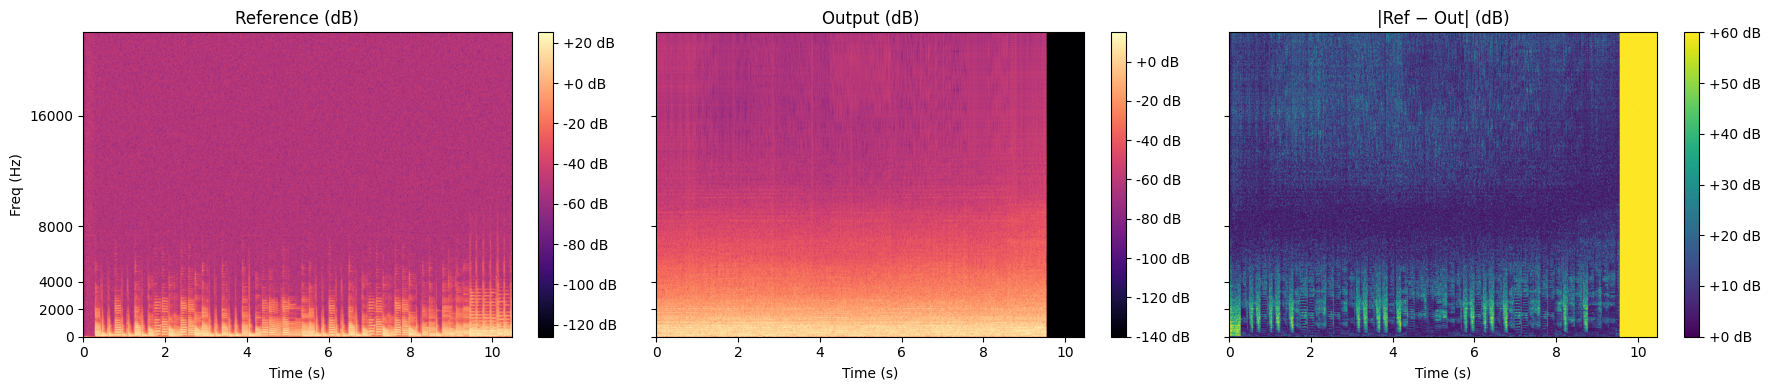

In [10]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

def plot_stft_comparison(y_true, y_pred, sample_rate=44100, n_fft=1024, hop_length=256):
    # squeeze channel dim if needed
    if y_true.dim() == 2 and y_true.size(0) == 1:
        y_true = y_true.squeeze(0)
    if y_pred.dim() == 2 and y_pred.size(0) == 1:
        y_pred = y_pred.squeeze(0)

    # STFT
    spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=1.0)
    S_true = spec(y_true)  # [freq_bins, time_frames]
    S_pred = spec(y_pred)

    # align time frames
    T = min(S_true.size(-1), S_pred.size(-1))
    S_true = S_true[..., :T]
    S_pred = S_pred[..., :T]

    # to dB
    S_true_db = 20 * torch.log10(S_true + 1e-7)
    S_pred_db = 20 * torch.log10(S_pred + 1e-7)
    S_diff = torch.abs(S_true_db - S_pred_db)

    # prepare freq/time vectors
    freq_bins = S_true_db.shape[0]
    times = np.arange(T) * hop_length / sample_rate
    freqs = np.linspace(0, sample_rate/2, freq_bins)

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
    im0 = axes[0].imshow(S_true_db.numpy(), origin='lower',
                         aspect='auto', cmap='magma',
                         extent=[times[0], times[-1], freqs[0], freqs[-1]])
    axes[0].set(title='Reference (dB)', xlabel='Time (s)', ylabel='Freq (Hz)')
    fig.colorbar(im0, ax=axes[0], format='%+2.0f dB')

    im1 = axes[1].imshow(S_pred_db.numpy(), origin='lower',
                         aspect='auto', cmap='magma',
                         extent=[times[0], times[-1], freqs[0], freqs[-1]])
    axes[1].set(title='Output (dB)', xlabel='Time (s)')
    fig.colorbar(im1, ax=axes[1], format='%+2.0f dB')

    im2 = axes[2].imshow(S_diff.numpy(), origin='lower',
                         aspect='auto', cmap='viridis',
                         vmin=0, vmax=60,
                         extent=[times[0], times[-1], freqs[0], freqs[-1]])
    axes[2].set(title='|Ref − Out| (dB)', xlabel='Time (s)')
    fig.colorbar(im2, ax=axes[2], format='%+2.0f dB')

    # set nice yticks at e.g. 0,2k,4k,8k,16k
    yticks = [0, 2000, 4000, 8000, 16000]
    for ax in axes:
        ax.set_yticks(yticks)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume y and y_hat are 1D torch tensors loaded from your validation set
# y, y_hat = ... 
plot_stft_comparison(ref, wet)




In [15]:
import torch
import torch.nn.functional as F
import torchaudio
import pandas as pd
import time
from pathlib import Path
from tqdm import tqdm

from toneEncoder import ToneEncoder
from generator import GeneratorFiLMGCN, CondNet
from generator import DeepFusionMLP, ResidualFusionMLP  # 根据你的实现路径调整
from losses import MRSTFTLoss
from helper import peak_normalize, loudness_match

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SR = 48000

def chunkify(wav: torch.Tensor, chunk_len: int):
    """
    将 wav 分成若干长度为 chunk_len 的片段，末尾不足时用 0 填充
    返回列表 [(start, end, segment), ...]
    """
    T = wav.size(-1)
    out = []
    for s in range(0, T, chunk_len):
        e = min(T, s + chunk_len)
        seg = wav[..., s:e]
        if e - s < chunk_len:
            seg = F.pad(seg, (0, chunk_len - (e - s)))
        out.append((s, e, seg))
    return out

def evaluate(split_csv, 
             tone_ckpt, 
             cond_ckpt, 
             fusion_ckpt, 
             gen_ckpt,
             out_csv):
    # 加载模型
    enc = ToneEncoder().to(DEVICE).eval()
    enc.load_state_dict(torch.load(tone_ckpt, map_location=DEVICE))
    cond_net = CondNet().to(DEVICE).eval()
    cond_net.load_state_dict(torch.load(cond_ckpt, map_location=DEVICE))
    fusion_mlp = ResidualFusionMLP().to(DEVICE).eval()
    fusion_mlp.load_state_dict(torch.load(fusion_ckpt, map_location=DEVICE))
    gen = GeneratorFiLMGCN().to(DEVICE).eval()
    gen.load_state_dict(torch.load(gen_ckpt, map_location=DEVICE))

    loss_fn = MRSTFTLoss(ffts=[1024], alpha_spec=1.0, alpha_time=0).to(DEVICE)

    df = pd.read_csv(split_csv)
    results = []
    chunk_len = SR * 1  # 1 秒一片

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Eval {split_csv}"):
        # 1) 读干 x 和 湿 y
        x, sr1 = torchaudio.load(row["di_file"])
        y, sr2 = torchaudio.load(row["filename"])
        # 单通道
        x = x.mean(0, keepdim=True);  y = y.mean(0, keepdim=True)
        # 重采样
        if sr1 != SR: x = torchaudio.functional.resample(x, sr1, SR)
        if sr2 != SR: y = torchaudio.functional.resample(y, sr2, SR)
        # 归一化 & 声音匹配
        x = peak_normalize(x);  y = peak_normalize(y)
        x = loudness_match(x, y)
        x, y = x.to(DEVICE), y.to(DEVICE)

        # 2) 计算 tone embedding φ_z
        with torch.no_grad():
            φ_z = enc(y).squeeze(0)         # [128]
        # 3) 计算 knob embedding φ_c
        c = torch.tensor([[row["gain"]]], dtype=torch.float32, device=DEVICE)  
        # 如果你有多个控制参数，请修改这里读取多维 c
        with torch.no_grad():
            φ_c = cond_net(c).squeeze(0)    # [16]
        # 4) Fuse
        φ_cat = torch.cat([φ_z, φ_c], dim=-1)  # [144]
        with torch.no_grad():
            φ = fusion_mlp(φ_cat.unsqueeze(0)).squeeze(0)  # [128]

        # 5) 分片推理、拼回
        y_hat = torch.zeros_like(x)
        t0 = time.time()
        for s, e, xi in chunkify(x, chunk_len):
            xi = xi.to(DEVICE)
            with torch.no_grad():
                yi = gen(xi, φ.unsqueeze(0)).clamp(-1, 1)
            yi = yi[..., : (e - s)]
            y_hat[..., s:e] = yi
        rtf = (time.time() - t0) / (x.size(-1) / SR)

        # 6) Loss
        mr = loss_fn(y_hat, y).item()

        results.append({
            "di_file": row["di_file"],
            "amp":     row["model"],
            "MRSTFT":  round(mr,4),
            "RTF":     round(rtf,4),
        })

    # 保存并打印
    out_df = pd.DataFrame(results)
    out_df.to_csv(out_csv, index=False)
    per_amp = out_df.groupby("amp")[["MRSTFT","RTF"]].mean().round(4)
    overall = out_df[["MRSTFT","RTF"]].mean().round(4)

    print(f"\n=== {split_csv} per-amp mean ===")
    print(per_amp)
    print(f"\n=== {split_csv} overall mean ===")
    print(overall)


evaluate(
    split_csv   = "test.csv",
    tone_ckpt   = "best_supcon_tone_encoder.pth",
    cond_ckpt   = "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_condnet_clip_3.5_bs_8.pth",
    fusion_ckpt = "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_fusionmlp_clip_3.5_bs_8.pth",
    gen_ckpt    = "Best_Con_Residual_Fusion_MRSTFT_1024nfft_0.9_0.1_film_gcn_generator_clip_3.5_bs_8.pth",
    out_csv     = "test_results.csv"
)


Eval test.csv: 100%|██████████| 911/911 [00:53<00:00, 16.90it/s]


=== test.csv per-amp mean ===
                          MRSTFT     RTF
amp                                     
Ecstasy 20th Anniversary  0.1044  0.0038
Fryette D60 More          0.1302  0.0040
Special Edition E670      0.2057  0.0037
USA IIC++                 0.1070  0.0040
USA Lead                  0.0818  0.0040

=== test.csv overall mean ===
MRSTFT    0.1066
RTF       0.0040
dtype: float64
